In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

# Introduction
- In this section we will talk about:
   <ol>
    <li>two curves for model validation, namely <b>learning curve</b> and <b>validation curve</b>, and</li>
    <li>methods for <b>searching the best possible set of hyperparameters</b> for a model</li>
    </ol>
  and showcase the complete workflow for model selection and tuning process.

# Bias-Variance Trade-off

## Prediction Error
- Prediction error in statistical modelling can be divided into two parts: <br><br>
$$ \text{prediction error} = \text{reducible error} +\text{irreducible error} $$<br>
- <b>Irreducible error</b> is error which cannot be improved by improving the model, it can come from <b>measurement errors</b> and <b>incapability of capturing all features</b> of the phenomenon.
- E.g. when one predicts IQ of people based on some features, features like the total amount of money parents spent on a person's education may not be exact (measurement error), or factors like influence of friends may be missing (incapability of capturing all features).
- <b>Reducible error</b>, on the other hand, can be improved, it consists of <b>bias error</b> and <b>variance error</b>.

## Breakdown of Reducible Error: Bias and Variance

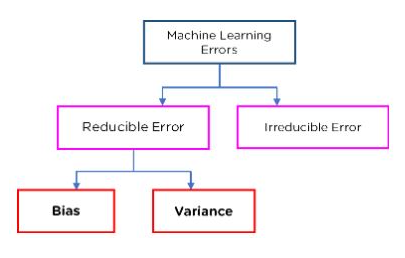

In [2]:
display.Image('img/5_prediction_error.png', width=400)

- <b>Bias error</b> is the <b>difference between the expected value of an approximate function and the true function (assuming there is a true function $f(x)$ represents target variable y with some noise $\epsilon$, i.e. $y = f(x) + \epsilon$)</b>. It is due to <b>incorrect assumptions in a model</b>. High bias can cause <b>underfitting</b> of training data, i.e. missing the relevant relations between features and target values.
- <b>Variance error</b> is the <b>variance of an approximate function</b>. It is an error in <b>sensitivity to small fluctuations in training data</b>. High variance can cause <b>overfitting</b> of training data, i.e. model is too sensitive to random noises.
- One prefers a model which <b>minimize both errors</b>: capture most relations between features and target values in training set (low bias) but at the same time can generalize to unseen data well (low variance). 

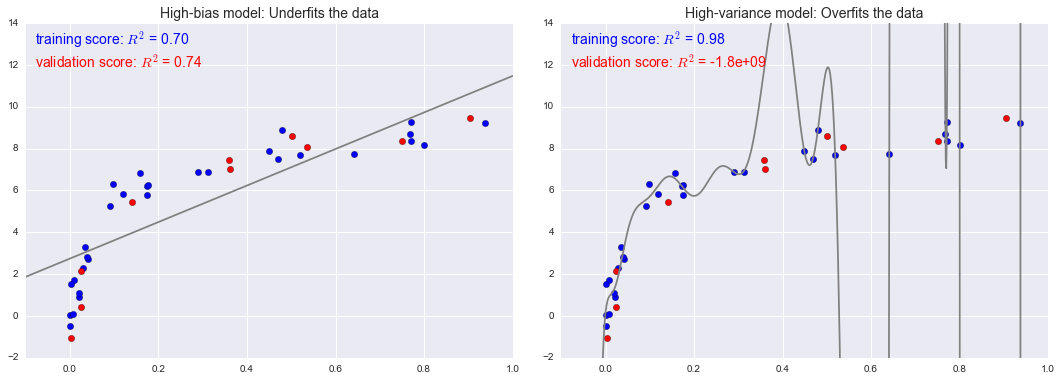

In [3]:
# high bias vs high variance
display.Image('img/5_high_bias_variance.png', width=800)

- The first diagram presents a model of high bias, the model is too simple and hence underfits the training data. The training score is similair to the validation score.
- The second diagram presents a model of high variance, the model is too complex and overfits the training data. The training score is much higher than the validation score.

## Bias and Variance Trade-off

- In reality, <b>there is usually a trade-off between bias and variance when model complexity varies</b> (not alwasys the case if one have enough data with all related features). 
- When the model complexity is low, both bias and variance is high.
- When the model complexity first increases, bias and variance both decreases.
- When the model complexity further increases, bias continue to decrease while the variance starts to increase.
- Therefore the sweet spot of model complexity is somehow in-between.

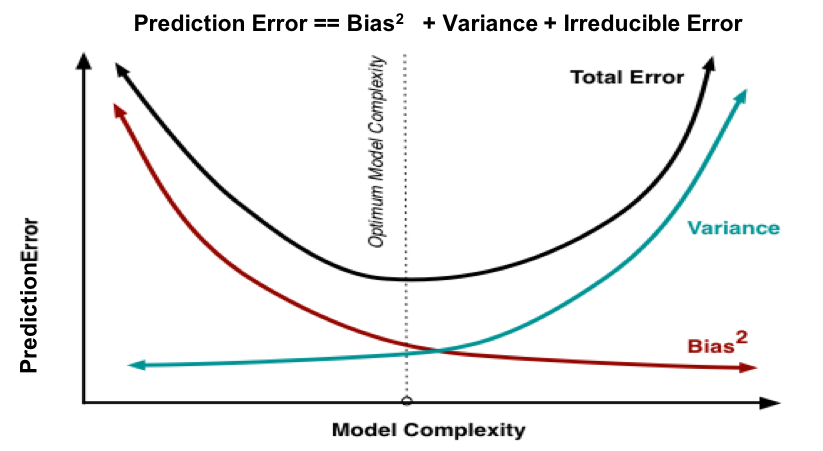

In [4]:
# how prediction error changes with model complexity
display.Image('img/5_bias_variance_trade_off.png', width=500)

- We use a <b>validation curve</b> to monitor the bias-variance trade-off which helps to find the opitmal model. 

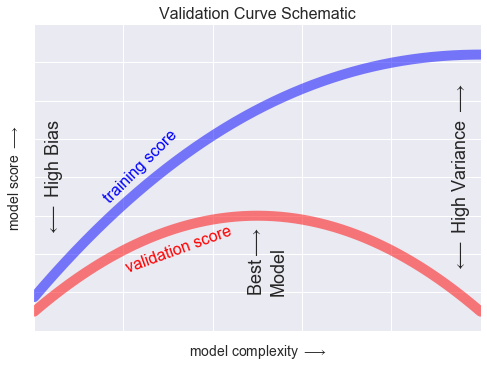

In [5]:
# a theoretical validation curve
display.Image('img/5_model_score_bias_variance.png', width=400)

# Determine optimal hyperparameter: Validation Curve
- <b>The choice of hyperparameters affect model complexity.</b>
- <b>Validation curve</b> is a curve of performance score (training/validation) versus a <b>single hyperparameter</b>.
- In actual hyperparameter tuning, since a model has sets of parameters to test at the same time (need to test for different <b>combinations</b> of hyperparameters), parameter search methods like <b>grid search, random search or Bayesian optimization</b> are used instead of using validation curve which could only test one hyperparameter at a time.
- However, if one wants <b>to find out which specific hyperparameter(s) is/are causing overfitting</b>, then validation curve can give a clear picture.

Suppose we are working on polynomial regression and want to determine the degree that could give us a good fit to training data so as a good generalization to unseen data.

In [6]:
# define polynomial regeression pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
# pipeline of polynomial regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [7]:
# generate training data
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)    # y = 10 - 1/(x+0.1)
    if err > 0:
        y += err * rng.randn(N)      # add randomness = err * random number from standard normal distribution
    return X, y

X, y = make_data(40)
print(X.shape, y.shape)

(40, 1) (40,)


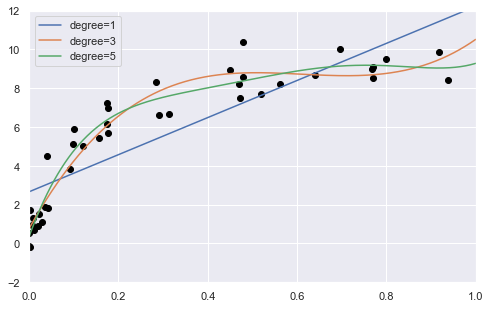

In [8]:
# view performance of model on test data
X_test = np.linspace(0, 1, 500)[:, None]
plt.figure(figsize = (8, 5))
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(0, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

In [9]:
# find the name of parameter to tune
model = PolynomialRegression()
print(f'Pipeline steps = {model.steps}')
print(f'Hyperparameters in PolynomialFeature() = {model.steps[0][1].get_params()}')

Pipeline steps = [('polynomialfeatures', PolynomialFeatures()), ('linearregression', LinearRegression())]
Hyperparameters in PolynomialFeature() = {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}


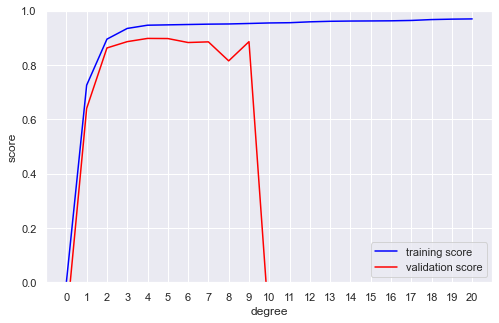

In [10]:
# plot validation curve
# validate score 
# we also plot train scor
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)   # parameter values to test: 0 to 20
train_score, val_score = validation_curve(
    estimator=PolynomialRegression(), 
    X=X, 
    y=y, 
    param_name='polynomialfeatures__degree', 
    param_range = degree, 
    cv=7
)
plt.figure(figsize = (8, 5))
plt.xticks(degree)
plt.plot(degree, np.mean(train_score, 1), color='blue', label='training score')    # mean score of 7 fits
plt.plot(degree, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

There are three observations:
- Training score is <b>always higher</b> than validation score, which makes sesnse as scoring a model with its training data usually gives good result.
- Training score <b>increases monotonically</b>, because a more complex model gives a better fit to the training data.
- Validation score <b>increases first and drops drastically</b> after degree=10, obviously the model is <b>overfitting</b> the training data.

From the curve we see that <b>degree=4 gives us the highest validation score with a normal train score</b>, so this is our best hyperparameter here.

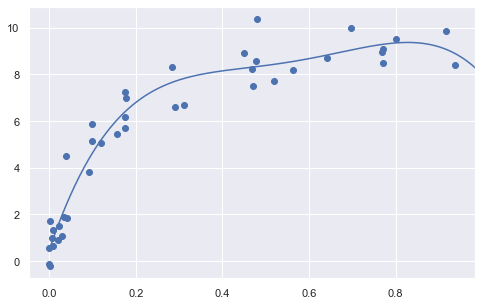

In [11]:
# view the best model
# luckily we have one hyperparameter to tune only, so using validation curve is enough to do the job
plt.figure(figsize = (8, 5))
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(4).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

# Determine optimal size of training data: Learning Curve
- <b>The optimal model complexity is also affected by the amount of training data</b>.
- <b>Learning curve</b> is a curve of performance score (training/validation) against number of training samples (another format is loss against number of training samples)
- It tells us the effect of adding more training data on model performances, hence <b>gives insight on about how many training data are required</b>.

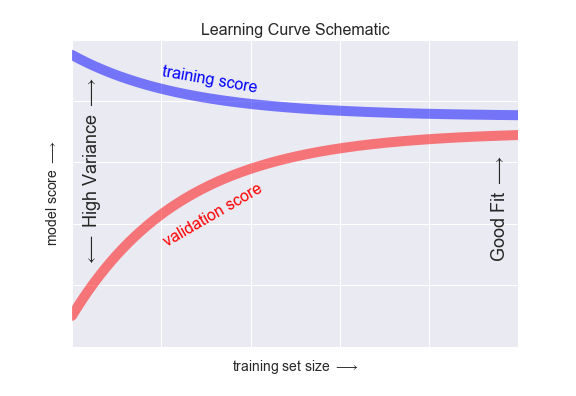

In [12]:
# performance learning curve
display.Image('img/5_learning_curve.png', width=400)

The above image represents what typical learning curves:
1. <b>Training score decreases with training size</b>, because a larger dataset is more difficult to fit perfectly.
2. <b>Validation score increases with training size</b>, because the generalization ability of a model increases when there are more training data to learn from.
3. <b>The two scores converge at some point and no further obvious change</b>, as more data won't provide further information to the model.

Let's look at new validation curves of the last model after adding more training data to see why learning curve is necessary.

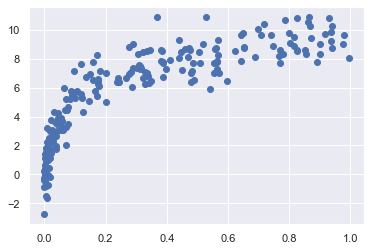

In [13]:
# generate 200 data points instead of 40
# since the random seed is fixed, the first 40 data points are the same as before
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

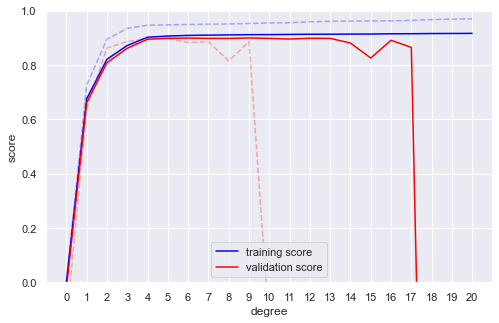

In [14]:
# plot validation curves of new model
# dotted lines are for old model
degree = np.arange(21)
train_score2, val_score2 = validation_curve(
    estimator=PolynomialRegression(), 
    X=X2, 
    y=y2, 
    param_name='polynomialfeatures__degree', 
    param_range = degree, 
    cv=7
)
plt.figure(figsize = (8, 5))
plt.xticks(degree)
plt.plot(degree, np.mean(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.mean(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.mean(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.mean(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

- This time the validation score drops after a much higher degree (degree=17), which <b>implies increasing training data can be useful (it leads to the training of a more complex model with good generalization ability possible)</b> in this case.
- In general the observation above is also true in deep learning. Models using deep neural networks are more complicated and can only generalize well if the size of training data is large enough.

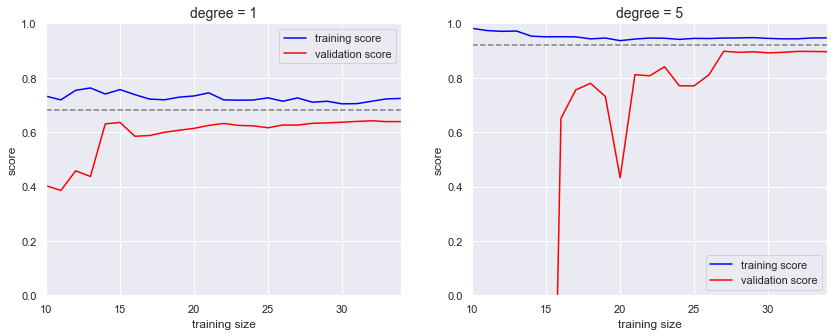

In [15]:
# learning curve with sklearn
from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i, degree in enumerate([1, 5]):
    N, train_lc, val_lc = learning_curve(
        estimator=PolynomialRegression(degree),
        X=X, 
        y=y, 
        cv=7,
        train_sizes=np.linspace(0.3, 1, 25)    # train proportion from 0.3 to 1
    )
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')    # mean of training and validation scores
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

- When degree=1, the model has <b>low variance hence the two scores converge fast</b>, increases in training data does not benefit model performance, so one should switch to a more complicated model but not increase training data.
- So we switch to a model with degree=5, since <b>the model has a higher variance, it overfits at first</b> and the validation score is low. 
- <b>By increasing data size, the complex model generalizes better so that the two scores converge enventually</b>, which takes much more data to converge but results in better performance compared with the first model.

# Hyperparameter Search
- Methodology of finding the optimal set of hyperparameters of a model corresponds to a specific dataset

## Grid Search
- Exhaustive <b>test over each possible set of hyperparameters</b> to determine the best one.

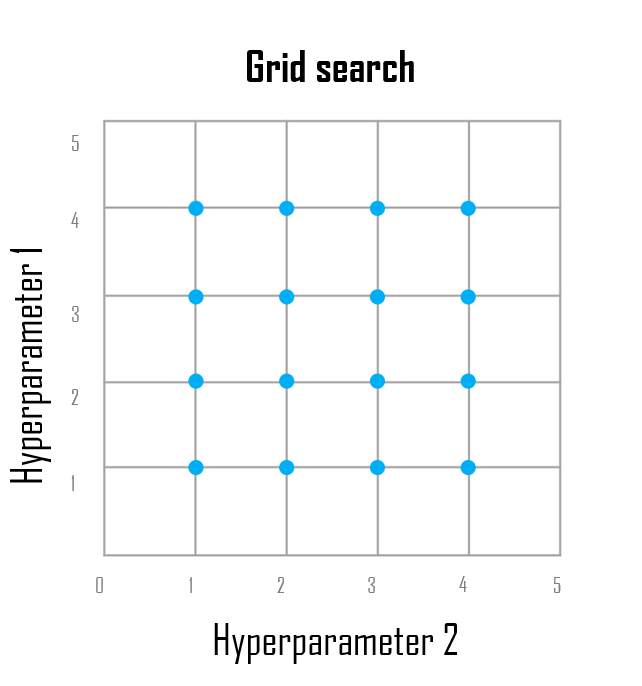

In [16]:
# already mentioned in section 4.1
display.Image('img/5_grid_search.png', width=300)

In [17]:
# let's see what parameters we can tune in linear regression model
print(f'pipeline steps = {model.steps}')
print(f'hyperparameters in LinearRegression = {model.steps[1][1].get_params()}')

pipeline steps = [('polynomialfeatures', PolynomialFeatures()), ('linearregression', LinearRegression())]
hyperparameters in LinearRegression = {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}


In [18]:
# grid search with sklearn
# use mean cross validation score to assess performance of each set of parameters
from sklearn.model_selection import GridSearchCV
param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept': [True, False],    # use constant in estimation formula or not
    'linearregression__normalize': [True, False]         # normalize each column of X or not
}    
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
%time grid.fit(X, y);

Wall time: 1.01 s


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [19]:
# best parameters
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

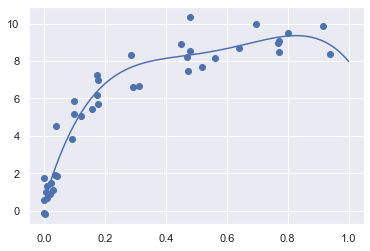

In [20]:
# performance of best model
model = grid.best_estimator_.fit(X, y)    # untrained estimator with best parameters
plt.scatter(X.ravel(), y)
# y_test = model.predict(X_test)    # need to fit training data again 
plt.plot(X_test.ravel(), y_test);

## Random Search
- <b>Sample randomly a fixed number of sets of hyperparameters for searching</b>, i.e. not all sets are tested
- Running time is drastically lower than grid search by sacrificing accuracy
- Research shows that random search can be more efficient than grid search with small trade-off in accuracy (https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a).
- More preferable than grid search when the number of hyperparameters is large/some hyperparameters are continuous/the model needs high computation power (such as neural network)

In [21]:
# random search with sklearn
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=PolynomialRegression(), 
    param_distributions = param_grid,
    n_iter = 20,
    random_state=0,
    cv=7
)
%time search.fit(X, y)

Wall time: 242 ms


RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_iter=20,
                   param_distributions={'linearregression__fit_intercept': [True,
                                                                            False],
                                        'linearregression__normalize': [True,
                                                                        False],
                                        'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])},
                   random_state=0)

In [22]:
# best parameters
search.best_params_

{'polynomialfeatures__degree': 5,
 'linearregression__normalize': False,
 'linearregression__fit_intercept': True}

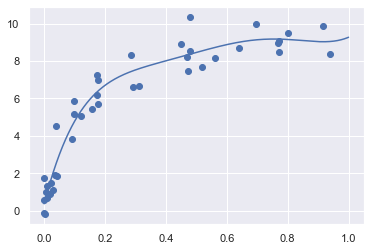

In [23]:
# performance of best model
model = search.best_estimator_    # untrained estimator with best parameters
plt.scatter(X.ravel(), y)
y_test = model.predict(X_test)    # need to fit training data again 
plt.plot(X_test.ravel(), y_test);

One could see that by setting n_iter=20, the running time is only about $\frac{1}{4}$ of grid search, but the two model estimations are pretty close.

Let's us summarise a complete model learning process using a diagram from sklearn.

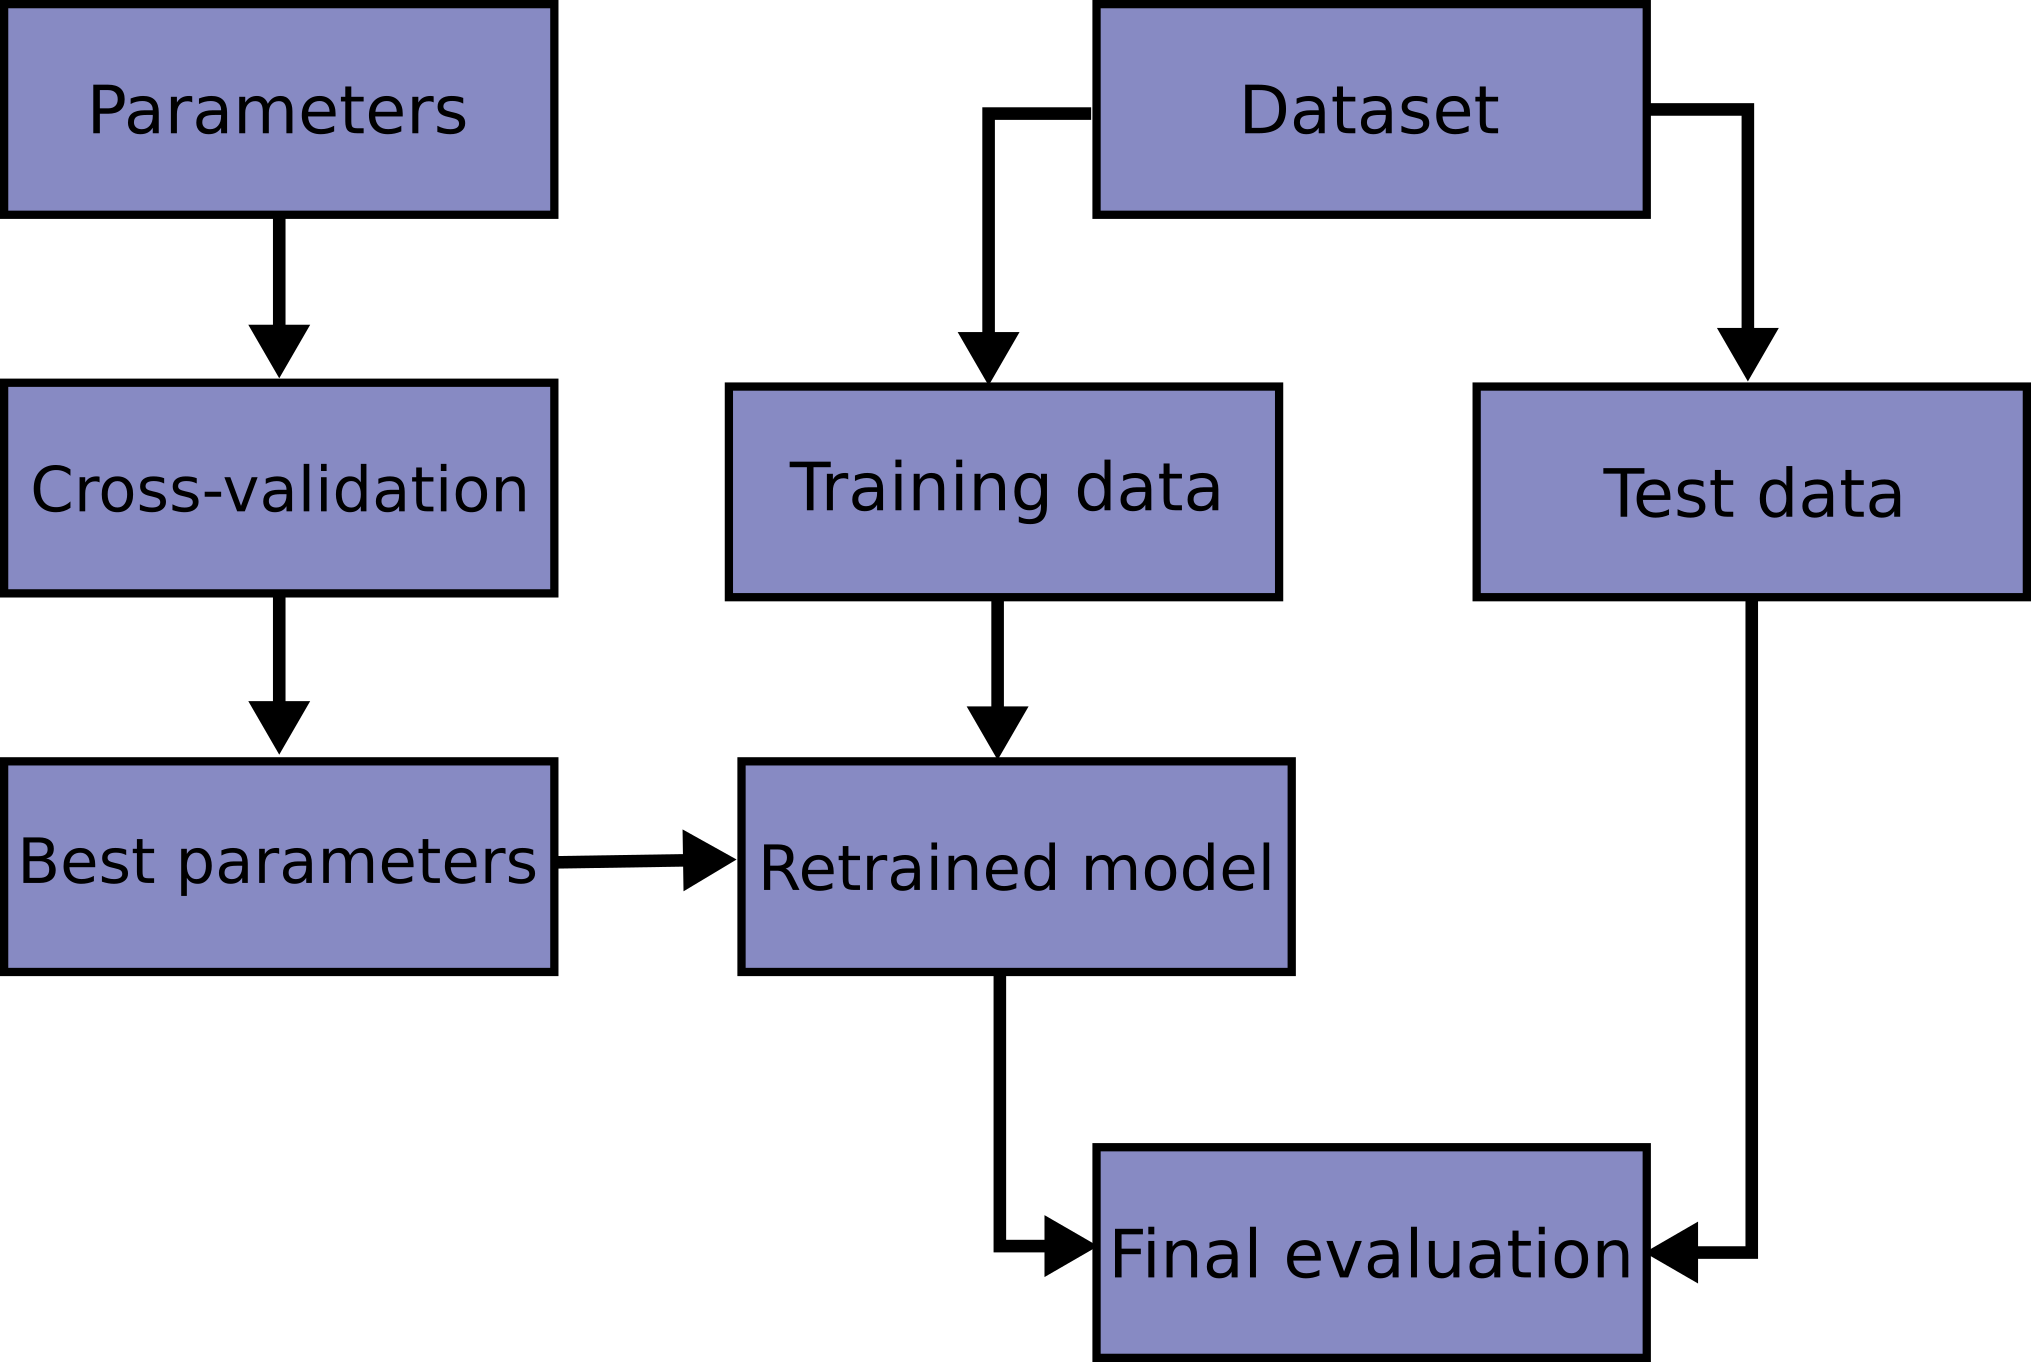

In [24]:
display.Image('img/5_model_evaluation_flow.png', width=400)